a)

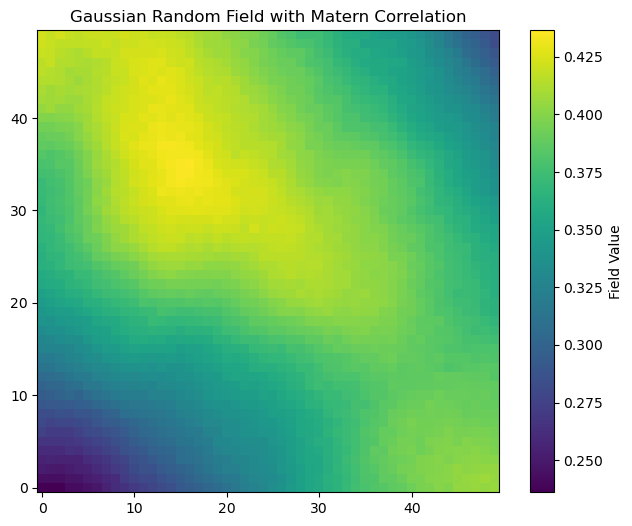

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

#Matern function
def matern_correlation(distances, scale):
    return (1 + scale * distances) * np.exp(-scale * distances)


#create grid
grid_size = 50
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
grid_x, grid_y = np.meshgrid(x, y)

#compute distances between each point
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
distances = cdist(grid_points, grid_points)

#generate correlation matrix, and adding a small term for numerical stability
corr_matrix = matern_correlation(distances, 0.3) + 1e-6 * np.eye(grid_size**2)

#generate Gaussian random field in the grid
mean = 0
variance = 1
field_values = np.random.multivariate_normal(mean * np.ones(grid_size**2), corr_matrix)
field_values_grid = field_values.reshape((grid_size, grid_size))

#plot
plt.figure(figsize=(8, 6))
plt.imshow(field_values_grid, cmap='viridis', origin='lower')
plt.colorbar(label='Field Value')
plt.title('Gaussian Random Field with Matern Correlation')
plt.show()


b)

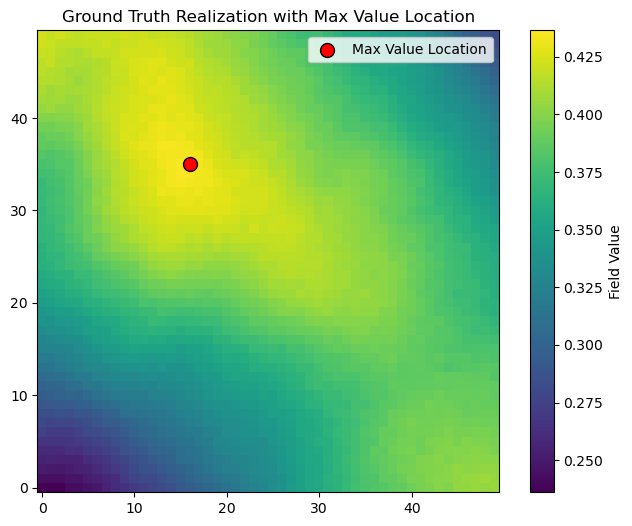

(0.4365391260421536, (35, 16))

In [34]:
#find maximum value and position
max_value = np.max(field_values_grid)
max_position = np.unravel_index(np.argmax(field_values_grid), field_values_grid.shape)

#plot ground truth
plt.figure(figsize=(8, 6))
plt.imshow(field_values_grid, cmap='viridis', origin='lower')
plt.colorbar(label='Field Value')
plt.scatter(max_position[1], max_position[0], color='red', label='Max Value Location', s=100, edgecolors='black')
plt.title('Ground Truth Realization with Max Value Location')
plt.legend()
plt.show()

max_value, max_position


c)

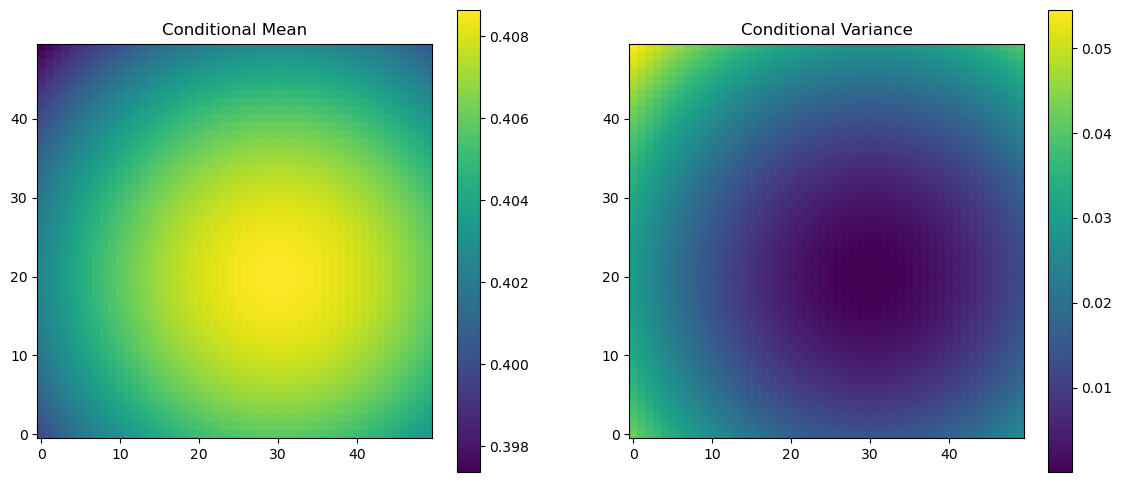

In [ ]:
from scipy.linalg import inv

#measurement noise variance
sigma_n = 0.01

#Cholesky decomp for more efficient field generation
L = np.linalg.cholesky(corr_matrix)  

#measurement location x1 = (20,30) 
x1 = (20, 30)  
d_x1 = field_values_grid[x1]  

#prior covariance matrix (K0)
K_x1_x1 = corr_matrix[x1[0]*grid_size + x1[1], x1[0]*grid_size + x1[1]]  #covariance at x1
K_x1_x = corr_matrix[x1[0]*grid_size + x1[1], :]  #covariance between x1 and other points
K_x_x1 = K_x1_x.reshape((grid_size, grid_size))  #covariance between other points and x1

# Computing the updated mean and variance for the grid
K_inv = 1 / (K_x1_x1 + sigma_n**2)

mu_t = np.zeros((grid_size, grid_size))
sigma_t = np.zeros((grid_size, grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        #covariance between each point and x1
        K_x_x1_ij = corr_matrix[i*grid_size + j, x1[0]*grid_size + x1[1]]  
        
        #conditional mean 
        mu_t[i, j] = K_x_x1_ij * K_inv * (d_x1 - 0)  # Assuming mean is 0 for the prior field

        #conditional variance 
        sigma_t[i, j] = corr_matrix[i*grid_size + j, i*grid_size + j] - K_x_x1_ij * K_inv * K_x_x1_ij

#plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(mu_t, cmap='viridis', origin='lower')
ax[0].set_title('Conditional Mean')
fig.colorbar(ax[0].imshow(mu_t, cmap='viridis', origin='lower'), ax=ax[0])
ax[1].imshow(sigma_t, cmap='viridis', origin='lower')
ax[1].set_title('Conditional Variance')
fig.colorbar(ax[1].imshow(sigma_t, cmap='viridis', origin='lower'), ax=ax[1])

plt.show()


d)

We have that:

$EI_t (x) = E[max(r(x)-m^*_t,0)|d(x_1),...,d(x_{t-1})]$

This is the expected value of $r(x)-m^*_t$ with all negative values having $0$ weight. ie:

$EI_t (x) = E[max(r(x)-m^*_t,0)|d(x_1),...,d(x_{t-1})] = \int_0^{\infty} P(r(x)-m^*_t > \tau) d\tau = \int_0^{\infty} P(r(x) > m^*_t + \tau) d\tau$

At each point $r(x) \sim \mathcal{N}(\mu_t(x), \sigma_t(x)^2)$

Which means that $Z(x) = \frac{r(x) - \mu_t(x)}{\sigma_t(x)} \sim \mathcal{N}(0,1)$

$\Rightarrow EI_t (x) = \int_0^\infty P(Z(x) > \frac{m_t^* + \tau - \mu_t(x)}{\sigma_t(x)}) d\tau$

$= \int_0^\infty 1 - \Phi (\frac{m_t^* + \tau - \mu_t(x)}{\sigma_t(x)}) d\tau$

Where $\Phi(k) = \int_{-\infty}^k \phi(t) dt \quad$ is the CDF.

and $\phi(t) = \frac{1}{\sqrt{2\pi}} exp(-\frac{t^2}{2}) \quad$ is the PDF.

$\Rightarrow EI_t(x) = \int_0^\infty \int_{Z(x)}^\infty \phi(t) dt d\tau$

By swapping the order of integration and solving the inner integral, we are left with:

$\int_{-\infty}^\infty \phi(t) \int_0^{(\sigma_t(x))(t-\frac{m_t^*-\mu_t(x)}{\sigma_t(x)})} d\tau dt = \int_{-\infty}^\infty \phi(t)\sigma_t(x)(t-\frac{m_t^*-\mu_t(x)}{\sigma_t(x)}) dt$


Now we can split the integral into two parts:


$EI_t(x) = \sigma_t(x) \left[ \int_{-\infty}^\infty t \phi(t) dt - \frac{m_t^* - \mu_t(x)}{\sigma_t(x)} \int_{-\infty}^\infty \phi(t) dt \right]$

Now we use the identity: 

$\int z \cdot exp(-\frac{z^2}{2}) dz = -exp(z^2) + C$

$\int_{-\infty}^\infty t \phi(t) dt = -exp(-t^2)|_{-\infty}^\infty = 0$

And the total probability for the standard normal distribution is 1:

$\int_{-\infty}^\infty \phi(t) dt = 1$

We get:

$EI_t(x) = \sigma_t(x) \left[ 0 - \frac{m_t^* - \mu_t(x)}{\sigma_t(x)} \right] = - \left( m_t^* - \mu_t(x) \right)$

Finally, we account for the second term, which represents the uncertainty (variance) at each grid point in the same way, and get:

$\underline{\underline{EI_t(x) = \left( \mu_t(x) - m^* \right) \Phi \left( \frac{\mu_t(x) - m^*}{\sigma_t(x)} \right) + \sigma_t(x) \phi \left( \frac{\mu_t(x) - m^*}{\sigma_t(x)} \right)}}$




e, f)

Iteration 1: New measurement at [0.41848391 0.40598256] -> 0.7716412803017593
Iteration 2: New measurement at [0.65805298 0.61307606] -> -0.2895097894744541
Iteration 3: New measurement at [0.91153161 0.92072586] -> -0.039519175481820934
Iteration 4: New measurement at [0.07255519 0.0540651 ] -> -0.4264309048066358
Iteration 5: New measurement at [0.76963004 0.20409544] -> -0.4279580482540535
Iteration 6: New measurement at [0.92034008 0.95114137] -> -0.09644045206260855
Iteration 7: New measurement at [0.40256739 0.31275729] -> 0.608820956496321
Iteration 8: New measurement at [0.39839375 0.56201646] -> -0.24465104128241927
Iteration 9: New measurement at [0.98653538 0.63332783] -> 0.9225943374356547
Iteration 10: New measurement at [0.72763194 0.24991411] -> 0.603246512459669


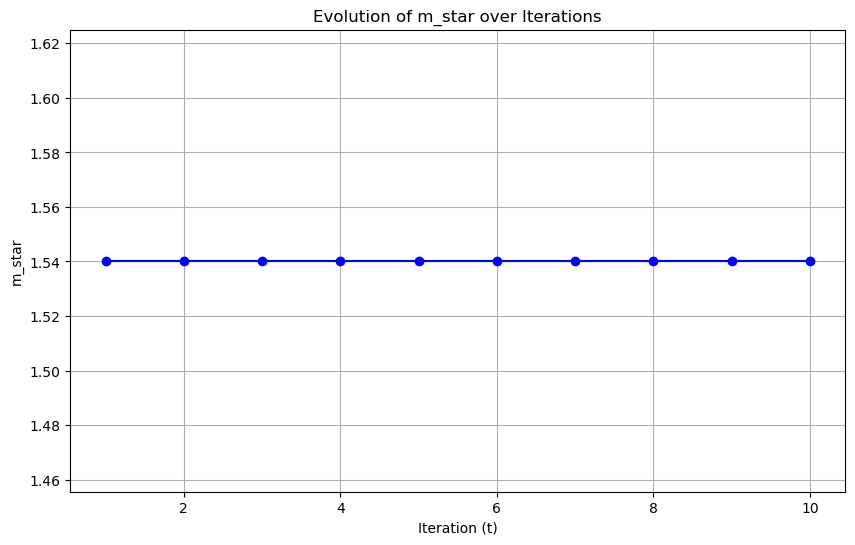

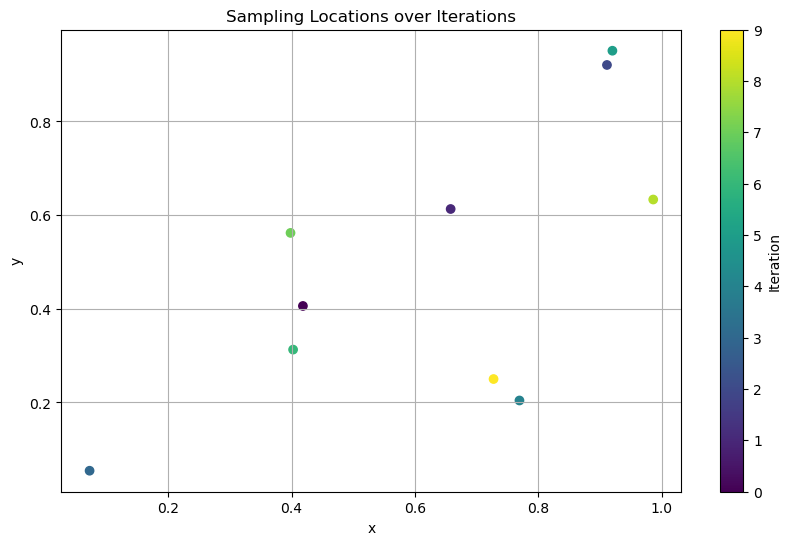

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.preprocessing import StandardScaler

#true function r(x) 
def r(x):
    return np.random.normal(0, 1)  # True function is N(0, 1)

#simulating measurements 
def objective_function_with_noise(x):
    epsilon = np.random.normal(0, 0.01) 
    return r(x) + epsilon  # Noisy observation

#EI function
def expected_improvement(x, model, X_sample, y_sample, xi=0.01):
    
    #predict mean and std at candidate point
    mu, sigma = model.predict(x.reshape(1, -1), return_std=True)
    
    #current best
    m_star = np.max(y_sample)
    
    #compute EI
    imp = mu - m_star - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    return -ei  # We negate it because we use a minimizer

#update model
def update_gp_model(model, X_sample, y_sample):
    model.fit(X_sample, y_sample)
    

#sequential optimization loop
def sequential_optimization(X_init, y_init, bounds, n_iter=10, sample_size=50):
    #initialize the GaussianProcessRegressor 
    kernel = Matern(length_scale=1.0, nu=1.5) 
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    
    #standardizing data 
    scaler = StandardScaler()
    X_init_scaled = scaler.fit_transform(X_init)
    y_init_scaled = scaler.fit_transform(y_init.reshape(-1, 1)).flatten()

    #fit model with initial data
    X_sample = X_init_scaled
    y_sample = y_init_scaled
    model.fit(X_sample, y_sample)

    #track m_star and sampling locations
    m_star_values = []  # to track m_star over iterations
    sampling_locations = []  # to track sampling locations
    
    #optimization loop
    for t in range(n_iter):
        #compute EI for all points
        sample_indices = np.random.choice(X_init.shape[0], sample_size, replace=False)
        X_sample_subset = X_init[sample_indices]
        
        EI_values = np.zeros(X_sample_subset.shape[0])
        for i, x in enumerate(X_sample_subset):
            EI_values[i] = expected_improvement(x, model, X_sample, y_sample)
        
        #select max EI
        max_ei_idx = np.argmax(EI_values)
        x0 = X_sample_subset[max_ei_idx]  # Select the point with maximum EI
        
        #add small random perturbation to avoid getting stuck in the corners
        x0 = x0 + np.random.uniform(-0.05, 0.05, size=x0.shape)
        
        #optimize EI to select the next candidate point
        res = minimize(expected_improvement, x0=x0, bounds=bounds, args=(model, X_sample, y_sample))
        x_next = res.x
        
        #ensure x_next is within bounds
        x_next = np.clip(x_next, bounds[0][0], bounds[0][1]) 
        
        #evaluate function at the next point 
        y_next = objective_function_with_noise(x_next)  # Get noisy measurement
        
        #update model with the new data point
        X_sample = np.vstack((X_sample, x_next))
        y_sample = np.append(y_sample, y_next)
        update_gp_model(model, X_sample, y_sample)
        
        #track m_star and sampling location
        m_star_values.append(np.max(y_sample))  
        sampling_locations.append(x_next)  
        
        print(f"Iteration {t+1}: New measurement at {x_next} -> {y_next}")
    
    return X_sample, y_sample, m_star_values, sampling_locations


X_init = grid_points 
y_init = field_values

#bounds
bounds = [(0, 1), (0, 1)] 

#run optimization for 10 iterations
X_final, y_final, m_star_values, sampling_locations = sequential_optimization(X_init, y_init, bounds, n_iter=10)


#plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(m_star_values) + 1), m_star_values, marker='o', color='b')
plt.xlabel('Iteration (t)')
plt.ylabel('m_star')
plt.title('Evolution of m_star over Iterations')
plt.grid(True)
plt.show()

sampling_locations = np.array(sampling_locations)

plt.figure(figsize=(10, 6))
plt.scatter(sampling_locations[:, 0], sampling_locations[:, 1], c=np.arange(len(sampling_locations)), cmap='viridis', marker='o')
plt.colorbar(label='Iteration')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampling Locations over Iterations')
plt.grid(True)
plt.show()


